In [1]:
# # Add the cloned directory to Python's path to allow importing from it
# import sys
# sys.path.append('./gen-rain')

import torch

# Now import using the valid module name with an underscore
from data import GaussianRainfieldGenerator
from models import JointRainDiffuser, train

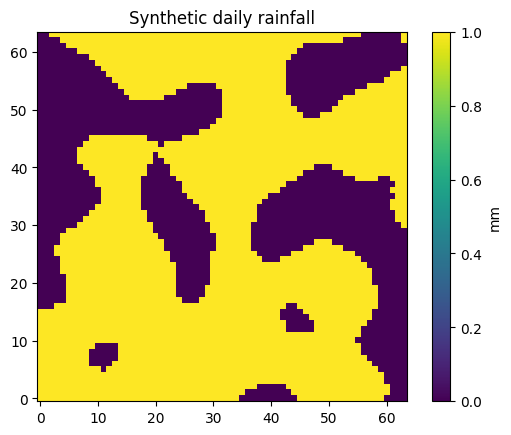

In [2]:
# ----------------------------------------------------------------
# Example usage inside Colab
# ----------------------------------------------------------------
if __name__ == "__main__":
    gen = GaussianRainfieldGenerator(
        grid_height = 64, grid_width = 64,
        length_scale = 0.1, wet_threshold = 0.4,
        amount_dist = "gamma", gamma_shape = 1.5, gamma_scale = 8.0, 
    )

    # draw a single field to verify
    field = gen.sample_precip(n_samples=1,occurrence_only=True)[0,0]  # (H, W)

    # quick visual check (works in notebooks):
    import matplotlib.pyplot as plt
    plt.imshow(field.cpu(), origin="lower")
    plt.colorbar(label="mm")
    plt.title("Synthetic daily rainfall")
    plt.show()

In [3]:
from torch.utils.data import DataLoader
rainset = gen.make_dataset(10_000)           # 10k synthetic days
loader  = DataLoader(rainset, batch_size=64, shuffle=True, pin_memory=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---- synthetic dataset from previous step --------------
# from synthetic_rain import GaussianRainfieldGenerator   # same file / import
gen = GaussianRainfieldGenerator(grid_height=16, grid_width=16)
rainset = gen.make_dataset(1000)
loader  = DataLoader(rainset, batch_size=64, shuffle=True,
                      num_workers=0, pin_memory=True)

In [ ]:
# ---- train ---------------------------------------------
model = JointRainDiffuser(T=1000, device=device)
train(model, loader, epochs=10, lr=1e-4, lam=10.0, device=device)

Epoch 01: Lmask=0.6937 | Lamt=0.9860
Epoch 02: Lmask=0.6922 | Lamt=0.9633
Epoch 03: Lmask=0.6911 | Lamt=0.9355
Epoch 04: Lmask=0.6898 | Lamt=0.9245
Epoch 05: Lmask=0.6862 | Lamt=0.8778
Epoch 06: Lmask=0.6816 | Lamt=0.8475
Epoch 07: Lmask=0.6712 | Lamt=0.8371
Epoch 08: Lmask=0.6537 | Lamt=0.7927
Epoch 09: Lmask=0.6285 | Lamt=0.7787
Epoch 10: Lmask=0.6080 | Lamt=0.7452


In [ ]:
# ---- sampling ------------------------------------------
@torch.no_grad()
def sample(model, n=4):
    H = W = 64
    # --- 1) sample mask via reverse discrete process ----
    x_t = torch.randint(0,2,(n,1,H,W), device=device)    # start from noise
    for t in reversed(range(1,model.disc.T+1)):
        t_batch = torch.full((n,), t, device=device)
        t_emb = time_embedding(t_batch, H, W, device)
        logits = model.unet_mask(torch.cat([x_t.float(), t_emb],1), 0)
        probs  = F.softmax(logits, 1)[:,1:2]             # prob(wet)
        x0_pred = (probs > 0.5).float()
        # simplistic posterior sample: copy pred
        x_t = x0_pred
    mask = x_t                                           # (n,1,H,W)
    # --- 2) sample intensity conditioned on mask --------
    y_t = torch.randn_like(mask)                         # Gaussian noise
    for t in reversed(range(1,model.cont.T+1)):
        t_b = torch.full((n,), t, device=device)
        t_emb = time_embedding(t_b, H, W, device)
        cond = torch.cat([y_t, mask], 1)
        eps_hat = model.unet_rain(torch.cat([cond, t_emb],1), 0)
        alpha_t = model.cont.alpha[t_b].view(-1,1,1,1)
        alpha_bar_t = model.cont.alpha_bar[t_b].view(-1,1,1,1)
        y0_pred = (y_t - (1 - alpha_t).sqrt() * eps_hat) / alpha_t.sqrt()
        if t > 1:
            noise = torch.randn_like(y_t)
            y_t = alpha_t.sqrt() * y0_pred + (1-alpha_t).sqrt() * noise
        else:
            y_t = y0_pred
    return (y_t * mask).cpu()             # final precip field

fields = sample(model, n=4)               # (4,1,64,64)

import matplotlib.pyplot as plt
for i in range(4):
    plt.subplot(2,2,i+1); plt.imshow(fields[i,0], origin='lower')
    plt.axis('off')
plt.suptitle("Jointly-generated synthetic precipitation")
plt.show()

In [ ]:
# ---- sampling ------------------------------------------
@torch.no_grad()
def sample(model, n=4):
    H = W = 16
    # --- 1) sample mask via reverse discrete process ----
    x_t = torch.randint(0,2,(n,1,H,W), device=device)    # start from noise
    for t in reversed(range(1,model.disc.T+1)):
        t_batch = torch.full((n,), t, device=device)
        t_emb = time_embedding(t_batch, H, W, device)
        logits = model.unet_mask(torch.cat([x_t.float(), t_emb],1), 0)
        probs  = F.softmax(logits, 1)[:,1:2]             # prob(wet)
        x0_pred = (probs > 0.5).float()
        # simplistic posterior sample: copy pred
        x_t = x0_pred
    mask = x_t                                           # (n,1,H,W)
    # --- 2) sample intensity conditioned on mask --------
    y_t = torch.randn_like(mask)                         # Gaussian noise
    for t in reversed(range(1,model.cont.T+1)):
        t_b = torch.full((n,), t, device=device)
        t_emb = time_embedding(t_b, H, W, device)
        cond = torch.cat([y_t, mask], 1)
        eps_hat = model.unet_rain(torch.cat([cond, t_emb],1), 0)
        alpha_t = model.cont.alpha[t_b].view(-1,1,1,1)
        alpha_bar_t = model.cont.alpha_bar[t_b].view(-1,1,1,1)
        y0_pred = (y_t - (1 - alpha_t).sqrt() * eps_hat) / alpha_t.sqrt()
        if t > 1:
            noise = torch.randn_like(y_t)
            y_t = alpha_t.sqrt() * y0_pred + (1-alpha_t).sqrt() * noise
        else:
            y_t = y0_pred
    return (y_t * mask).cpu()             # final precip field

fields = sample(model, n=4)               # (4,1,64,64)

import matplotlib.pyplot as plt
for i in range(4):
    plt.subplot(2,2,i+1); plt.imshow(fields[i,0], origin='lower')
    plt.axis('off')
plt.suptitle("Jointly-generated synthetic precipitation")
plt.show()

In [ ]:
# ----------------------------------------------------------------
# Example usage inside Colab
# ----------------------------------------------------------------
if __name__ == "__main__":
    gen = GaussianRainfieldGenerator(
        grid_height = 16, grid_width = 16,
        length_scale = 0.1, wet_threshold = 0.4,
        amount_dist = "gamma", gamma_shape = 1.5, gamma_scale = 8.0,
    )

    # draw a single field to verify
    field = gen.sample_precip(1)[0,0]  # (H, W)

    # quick visual check (works in notebooks):
    import matplotlib.pyplot as plt
    plt.imshow(field.cpu(), origin="lower")
    plt.colorbar(label="mm")
    plt.title("Synthetic daily rainfall")
    plt.show()